In [ ]:
!pip install transformers datasets evaluate rouge_score torch sentencepiece -q

# Imports

In [ ]:
from datasets import load_dataset,  concatenate_datasets
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
import torch
import numpy as np
import matplotlib.pyplot as plt
import evaluate

# Load Datasets

In [ ]:
cnn = load_dataset("cnn_dailymail", "3.0.0")
samsum = load_dataset("nyamuda/samsum")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Dataset Summary

In [ ]:
print("\n--- Dataset Samples ---")
print("CNN/DailyMail sample article:\n", cnn["train"][0]["article"][:500])
print("\nCNN/DailyMail summary:\n", cnn["train"][0]["highlights"])

print("\nSAMSum sample dialogue:\n", samsum["train"][0]["dialogue"])
print("\nSAMSum summary:\n", samsum["train"][0]["summary"])


--- Dataset Samples ---
CNN/DailyMail sample article:
 LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s

CNN/DailyMail summary:
 Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .

SAMSum sample dialogue:
 Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

SAMSum summary:
 Amanda baked cookies and will bring Jerry some tomorrow.


## EDA

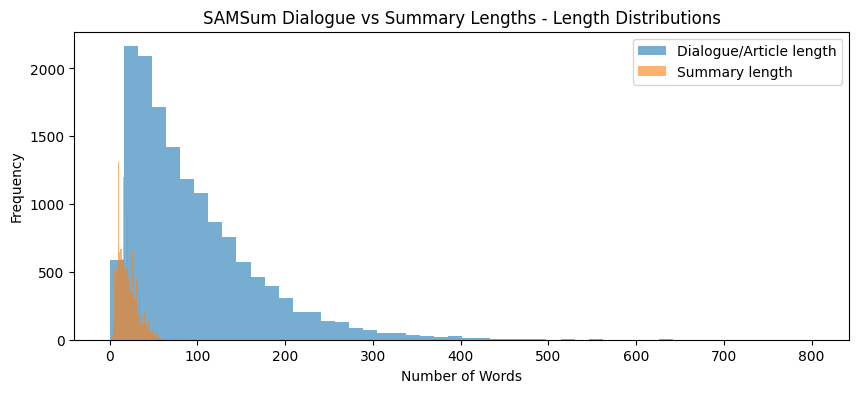

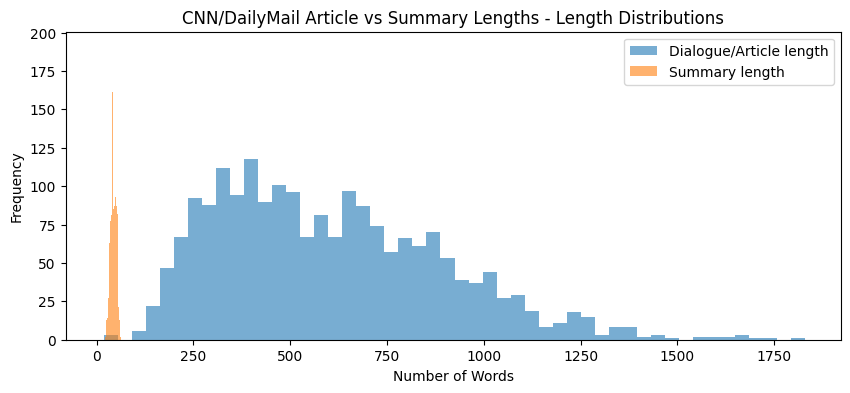

In [ ]:
def plot_length_distribution(dataset, text_field, summary_field, title):
    text_lens = [len(x.split()) for x in dataset[text_field]]
    sum_lens = [len(x.split()) for x in dataset[summary_field]]

    plt.figure(figsize=(10, 4))
    plt.hist(text_lens, bins=50, alpha=0.6, label="Dialogue/Article length")
    plt.hist(sum_lens, bins=50, alpha=0.6, label="Summary length")
    plt.title(f"{title} - Length Distributions")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_length_distribution(
    samsum["train"],
    "dialogue", "summary",
    "SAMSum Dialogue vs Summary Lengths"
)

plot_length_distribution(
    cnn["train"].select(range(2000)),
    "article", "highlights",
    "CNN/DailyMail Article vs Summary Lengths"
)


# Summarization Techniques

##  GPT-2 Zero-Shot Summarization

In [ ]:
print("\n--- GPT-2 Zero-Shot Summarization ---")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

text = samsum["test"][0]["dialogue"]
input_ids = gpt2_tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
summary_ids = gpt2_model.generate(input_ids, max_new_tokens=50, num_beams=4, early_stopping=True)
print("Generated summary:\n", gpt2_tokenizer.decode(summary_ids[0], skip_special_tokens=True))



--- GPT-2 Zero-Shot Summarization ---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated summary:
 Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
Amanda: Bye bye
Amanda: Bye bye
Amanda: Bye bye
Amanda: Bye bye
Amanda: Bye bye
Amanda: Bye bye
Amanda: Bye bye


## BART and T5 Summarization

In [ ]:
print("\n--- BART and T5 Summarization ---")
bart_pipe = pipeline("summarization", model="facebook/bart-large-cnn")
t5_pipe = pipeline("summarization", model="t5-small")

sample_text = samsum["test"][1]["dialogue"]
print("\nOriginal dialogue:\n", sample_text)
print("\nBART summary:\n", bart_pipe(sample_text, max_length=60, min_length=10, do_sample=False)[0]['summary_text'])
print("\nT5 summary:\n", t5_pipe(sample_text, max_length=60, min_length=10, do_sample=False)[0]['summary_text'])



--- BART and T5 Summarization ---


Device set to use cuda:0
Device set to use cuda:0



Original dialogue:
 Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

BART summary:
 Rob: Is this his only stand-up? Eric: Sure. Rob: Idk. There are some of his stand-ups on youtube. Eric: MACHINE! Rob: That's so gr8! Eric: Gr8!


Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



T5 summary:
 Rob: I know! I especially like the train part! Rob: Hahaha! No one talks to the machine like that! I'll watch some of his stand-ups on youtube .


## PEGASUS Summarization

In [ ]:
print("\n--- PEGASUS Summarization ---")
pegasus_pipe = pipeline("summarization", model="google/pegasus-xsum")
print("\nPEGASUS summary:\n", pegasus_pipe(sample_text, max_length=60, min_length=10, do_sample=False)[0]['summary_text'])


--- PEGASUS Summarization ---


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0



PEGASUS summary:
 Rob: That's so gr8!


# Dataset preprocessing

In [ ]:
def count_words(example):
    return {"word_count": len(example["article"].split())}

# Add word count column
cnn["train"] = cnn["train"].map(count_words)
cnn["validation"] = cnn["validation"].map(count_words)

# Filter out long articles (keep only <= 600 words)
cnn_filtered_train = cnn["train"].filter(lambda x: x["word_count"] <= 600)
cnn_filtered_val = cnn["validation"].filter(lambda x: x["word_count"] <= 600)

# Rename columns for compatibility with SAMSum (dialogue-summary format)
cnn_filtered_train = cnn_filtered_train.rename_columns({
    "article": "dialogue",
    "highlights": "summary"
})
cnn_filtered_val = cnn_filtered_val.rename_columns({
    "article": "dialogue",
    "highlights": "summary"
})



In [ ]:
print("\nCombining CNN/DailyMail and SAMSum subsets...")

# Select a manageable subset for Colab

# CNN dataset
cnn_small = cnn_filtered_train.select(range(200))
cnn_val = cnn_filtered_val.select(range(40))

# SAMSum dataset
samsum_small = samsum["train"].select(range(200))
samsum_val = samsum["validation"].select(range(40))

combined_train = concatenate_datasets([cnn_small, samsum_small])
val_combined = concatenate_datasets([
    cnn["validation"].select(range(100)).rename_columns({"article": "dialogue", "highlights": "summary"}),
    samsum["validation"].select(range(100))
])

print("Combined training size:", len(combined_train))
print("Combined validation size:", len(val_combined))


Combining CNN/DailyMail and SAMSum subsets...
Combined training size: 400
Combined validation size: 200


# Create Model

In [ ]:
model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


In [ ]:
def preprocess_function(batch):
    inputs = [x for x in batch["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=batch["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_train = cnn_small.map(preprocess_function, batched=True, remove_columns=cnn_small.column_names)
tokenized_val = cnn_val.map(preprocess_function, batched=True, remove_columns=cnn_val.column_names)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

metric = evaluate.load("rouge")

## Compute metrics function

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Handle tuple case (predictions, ...)
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Convert to numpy arrays (some models return lists of variable lengths)
    predictions = np.array(predictions, dtype=object)
    labels = np.array(labels, dtype=object)

    decoded_preds, decoded_labels = [], []

    for i in range(len(predictions)):
        pred_ids = predictions[i]
        label_ids = labels[i]

        # Flatten if nested (some outputs come batched twice)
        if isinstance(pred_ids, (list, np.ndarray)) and len(pred_ids) > 0 and isinstance(pred_ids[0], (list, np.ndarray)):
            pred_ids = pred_ids[0]

        clean_pred, clean_label = [], []

        # Clean and filter prediction IDs
        for t in pred_ids:
            try:
                val = int(t)
                if 0 <= val < tokenizer.vocab_size:  # valid token range
                    clean_pred.append(val)
            except (ValueError, OverflowError, TypeError):
                continue

        # Clean and filter label IDs
        for t in label_ids:
            try:
                val = int(t)
                if val != -100 and 0 <= val < tokenizer.vocab_size:
                    clean_label.append(val)
            except (ValueError, OverflowError, TypeError):
                continue

        # Decode safely
        decoded_preds.append(tokenizer.decode(clean_pred, skip_special_tokens=True))
        decoded_labels.append(tokenizer.decode(clean_label, skip_special_tokens=True))

    # Compute ROUGE in smaller chunks (avoid RAM overflow)
    batch_size = 20
    rouge_results = []
    for i in range(0, len(decoded_preds), batch_size):
        batch_preds = decoded_preds[i:i + batch_size]
        batch_labels = decoded_labels[i:i + batch_size]
        result = metric.compute(predictions=batch_preds, references=batch_labels, use_stemmer=True)
        rouge_results.append(result)

    # Average ROUGE scores
    final_scores = {}
    for key in rouge_results[0]:
        values = []
        for res in rouge_results:
            val = res[key]
            # If "val" is a simple float
            if isinstance(val, (float, np.floating)):
                values.append(val)
            else:
                # Normal case: use .mid.fmeasure
                values.append(val.mid.fmeasure)
        final_scores[key] = np.mean(values) * 100

    return final_scores


## Fine-tuning model

In [ ]:

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",      # corrected key name
    learning_rate=3e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=2,
    logging_steps=200,
    save_total_limit=1,
    report_to="none",
    eval_accumulation_steps=8,
    dataloader_num_workers=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2056553722.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Training

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.450309,4.073681,0.176593,3.717074,3.887434


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=100, training_loss=1.4890884399414062, metrics={'train_runtime': 183.9447, 'train_samples_per_second': 1.087, 'train_steps_per_second': 0.544, 'total_flos': 184051516637184.0, 'train_loss': 1.4890884399414062, 'epoch': 1.0})

# Testing

## Custom Test Set

In [ ]:
print("\n--- Custom Summarization Test ---")

custom_dialogue = """
A: Hey, did you finish the AI assignment?
B: Not yet, I’m stuck on the data preprocessing part.
A: I used pandas to clean the data, it worked fine.
B: Oh nice, can you share the code later?
A: Sure, I’ll send it to you after lunch.
"""

custom_article = """
A powerful earthquake struck western Nepal on Friday night, causing significant damage to homes and infrastructure.
Rescue teams have been deployed to affected areas in Jajarkot and Rukum districts, where dozens of people are feared injured.
The tremors were felt as far away as Kathmandu and parts of northern India.
Authorities have urged residents to remain cautious as aftershocks continue.
"""


--- Custom Summarization Test ---


## Testing the model

In [ ]:
# Ensure model is on GPU
model.to("cuda")

# Tokenize input and move to the same device
inputs = tokenizer([custom_article], max_length=512, truncation=True, return_tensors="pt").to("cuda")

# Generate summary
summary_ids = model.generate(**inputs, max_length=60, min_length=10, num_beams=4)

# Decode result
print("Generated summary:\n", tokenizer.decode(summary_ids[0], skip_special_tokens=True))

Generated summary:
 Rescue teams deployed to affected areas in Jajarkot and Rukum districts .
Dozens of people are feared injured and authorities urge residents to remain cautious .
Tremors felt as far away as Kathmandu and parts of northern India .
